# Dealing with the time-axis

This notebook shows some strategies to deal with time-axis related issues. Here we are focusing mostly on python based solutions, but some of these tips can be adapted to other tools. 

In [1]:
## This is setup for the plots later on in the notebook - on the website this
## cell (and the cells making the diagrams) is hidden by default, using the 'hide-input' cell tag

import matplotlib
import matplotlib.pyplot as plt
import numbers
import numpy

def draw_chunks(ax, size = (10, 8), nchunks = (5, 2), chunk_size = None, chunk_color = None):
    """
    Draw a chunk diagram
    
    Args:
        ax:          matplotlib.pyplot axis to draw on
        size:        size of the array (x, y)
        nchunks:     number of chunks (x, y)
        chunk_size:  size of each chunk (x, y) (default size/nchunks)
        chunk_color: colour of each chunk (array with shape nchunks)
    """
    
    spacing = 0.1
    
    if chunk_size is None:
        chunk_size = (None, None)
        
    if chunk_color is None:
        chunk_color = numpy.full(nchunks, 'wheat')
    else:
        chunk_color = numpy.asarray(chunk_color)
        
    # Fill in None values
    chunk_size = tuple(chunk_size[i] if chunk_size[i] is not None else size[i] / nchunks[i]
                        for i in range(2))
    
    if isinstance(chunk_size[0], numbers.Number):
        xsize = numpy.full(nchunks[0], chunk_size[0]) - spacing
    else:
        xsize = numpy.asarray(chunk_size[0]) - spacing
        
    if isinstance(chunk_size[1], numbers.Number):
        ysize = numpy.full(nchunks[1], chunk_size[1]) - spacing
    else:
        ysize = numpy.asarray(chunk_size[1]) - spacing

                        
    # Chunk cell centre
    xc = (numpy.arange(nchunks[0], dtype='f') + 0.5) * (size[0] / nchunks[0])
    yc = (numpy.arange(nchunks[1], dtype='f') + 0.5) * (size[1] / nchunks[1])
    
    for ii in range(nchunks[0]):
        for jj in range(nchunks[1]):
            box = matplotlib.patches.Rectangle((xc[ii] - xsize[ii]/2,
                                                yc[jj] - ysize[jj]/2),
                                               xsize[ii],
                                               ysize[jj], 
                                               facecolor=chunk_color[ii,jj], edgecolor='black')
            
            ax.add_patch(box)
            
    ax.set_xbound(0, size[0])
    ax.set_ylim(0, size[1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    

## Useful python packages

If you are a {ref}`python` user, the most useful package to deal with time is {ref}`pandas<pyanalysis>`, {ref}`calendar<pyanalysis>` and {term}`dask` .



#### Command-line tools

{ref}`cdo` and {ref}`nco` also offer some useful.

http://nco.sourceforge.net/nco.html#Timeseries-Reshaping-mode_002c-aka-Splitting

#### Other languages (Matlab, R, etc.)

While we're not aware of anything quite as nice as Xarray and Dask for other languages, most languages have libraries for reading NetCDF files and working with MPI.

If you have suggestions for other libraries we can list here please let us know by [opening a ticket](https://github.com/ACDguide/BigData/issues/new)

## Common Tasks

The chunking illustrations in this section show approximately how these operations are done in Xarray + Dask, to give an idea of their complexity when working with large datasets and a basic idea of how these operations can be implemented manually. Normal arrows mean one chunk on the left gets mapped to one chunk on the right, a left square bracket means the number of chunks is reduced after this operation, a right square bracket means the number of chunks is increased. The most intensive operations are rechunking, as these require a lot of data in-memory, which are indicated with a large square bracket on both left and right.

A *'reduce'* operation lowers the number of dimensions (e.g. a mean along the time axis). A *'map'* operation keeps the array size the same (e.g. a rolling mean)

Tasks can be combined - you might calculate a climatology of 90th percentiles for each day in the year, or resample daily data to monthly maximums.

### Min / Max / Mean / Stddev

Functions like these are pretty simple to calculate regardless of dataset size, as they don't require the entire dataset to be in memory. You can just loop over the dimension to be reduced calculating value so far up to that step

In pseudocode (in Python you're better off using `data.min(axis=0)`, as that's optimised compared to a loop)

```python
for t in range(data.shape[0]):
    out_min = np.minimum(out_min, data[t,...])
    out_max = np.maximum(out_max, data[t,...])
    out_sum = out_sum + data[t,...]
    
out_mean = out_sum / data.shape[0]
```

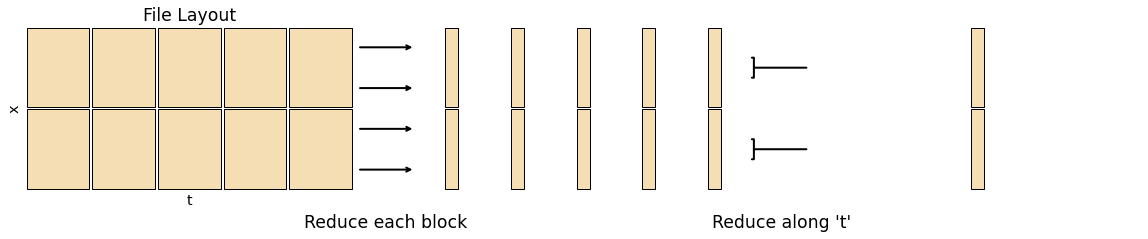

In [2]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20,3))

draw_chunks(axs[0])
axs[0].set_xlabel('t', fontsize='x-large')
axs[0].set_ylabel('x', fontsize='x-large')
axs[0].set_title('File Layout', fontsize='xx-large')

draw_chunks(axs[1], chunk_size=(0.5, None))

draw_chunks(axs[2], nchunks=(1, 2), chunk_size=(0.5, None))

for i in range(4):
    h = 1/4 * (i+0.5)
    conn = matplotlib.patches.ConnectionPatch((1.02, h), (-0.02, h), axs[0].transAxes, axs[1].transAxes, arrowstyle='->', linewidth=2)
    fig.add_artist(conn)

for i in range(2):
    h = 1/2 * (i+0.5)
    conn = matplotlib.patches.ConnectionPatch((1.02, h), (-0.02, h), axs[1].transAxes, axs[2].transAxes, arrowstyle=']-', linewidth=2)
    fig.add_artist(conn)
    
fig.add_artist(matplotlib.text.Text(0.375, -0.05, "Reduce each block", fontsize='xx-large',  ha='center', transform=fig.transFigure))
fig.add_artist(matplotlib.text.Text(0.65, -0.05, "Reduce along 't'", fontsize='xx-large',  ha='center', transform=fig.transFigure))

None

**Resources**

 - **Numpy** [statistics functions](https://numpy.org/doc/stable/reference/routines.statistics.html)
 - **Dask** also has optimised implementations for its arrays, e.g. [dask.array.mean](https://docs.dask.org/en/latest/array-api.html#dask.array.mean)
 - **Xarray** functions work the same as numpy, but keep the xarray metadata and you can use dimension names instead of axis numbers. [Weighted](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.weighted.html) operations are also available
 - **CDO** `cdo --operators | grep fld` will give a list of basic statistics operations
 
**Demonstrations**
 - Python - [Weighted Mean](http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html) from Xarray documentation

### Percentiles / Median

Percentiles are much trickier to calculate than basic statistics. To find the percentiles for a grid cell, you have to load the whole timeseries into memory, sort that timeseries, then find the value $N\%$ along that sorted timeseries. For a large dataset this becomes very costly, especially since most datasets are stored in a way optimised for loading the whole domain at a single time rather than the timeseries at a single point.

When there are `NAN` values in the timeseries percentiles become even harder to calculate, as the `NAN` values must be discarded by the algorithm.

There are approximate ways to compute percentiles that don't require the whole dataset in memory such as [T-digest](https://github.com/tdunning/t-digest)

Memory concerns are less of an issue when calculating percentiles on a subset of the data - e.g. when calculating climatologies.

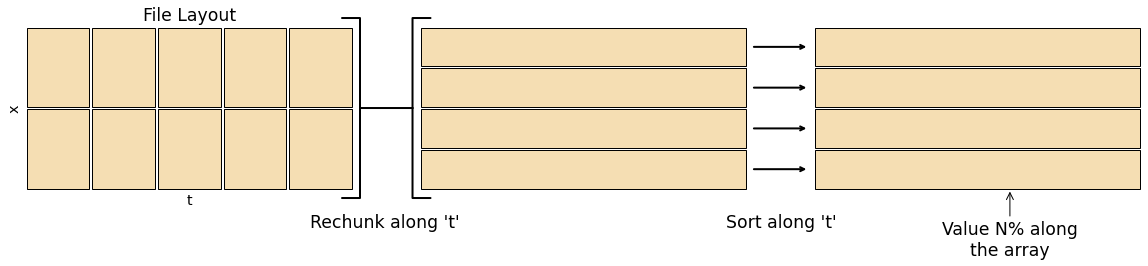

In [3]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20,3))

draw_chunks(axs[0])
axs[0].set_xlabel('t', fontsize='x-large')
axs[0].set_ylabel('x', fontsize='x-large')
axs[0].set_title('File Layout', fontsize='xx-large')

draw_chunks(axs[1], nchunks=(1, 4))

draw_chunks(axs[2], nchunks=(1, 4))
axs[2].annotate('Value N% along\nthe array', (0.6, 0), (0.6, -0.4), 'axes fraction', 'axes fraction', fontsize='xx-large', arrowprops={'arrowstyle': '->'}, ha='center')

regrid_conn = matplotlib.patches.ConnectionPatch((1.02, 0.5), (-0.02, 0.5), axs[0].transAxes, axs[1].transAxes, arrowstyle=']-[', mutation_scale=90, linewidth=2)
fig.add_artist(regrid_conn)

for i in range(4):
    h = 1/4 * (i+0.5)
    sort_conn = matplotlib.patches.ConnectionPatch((1.02, h), (-0.02, h), axs[1].transAxes, axs[2].transAxes, arrowstyle='->', linewidth=2)
    fig.add_artist(sort_conn)
    
fig.add_artist(matplotlib.text.Text(0.375, -0.05, "Rechunk along 't'", fontsize='xx-large',  ha='center', transform=fig.transFigure))
fig.add_artist(matplotlib.text.Text(0.65, -0.05, "Sort along 't'", fontsize='xx-large',  ha='center', transform=fig.transFigure))

None

### Time Resampling

Time resampling changes the temporal frequency of a dataset, say from hourly to daily. You can generally specify the operation to perform - min, mean, max etc. if going from a higher to lower frequency, or how values are interpolated if going from lower to higher frequency.

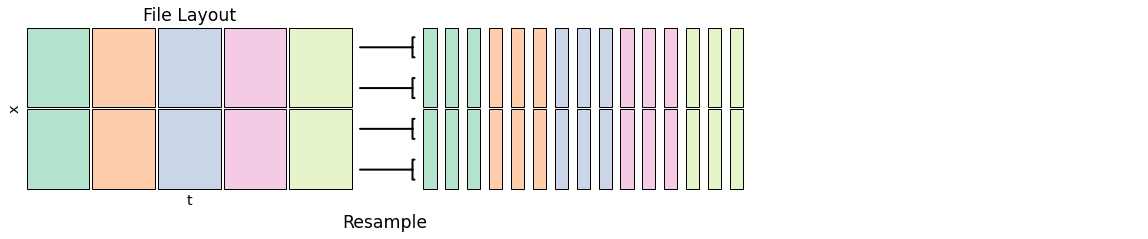

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20,3))

colors = numpy.stack([['#b3e2cd', '#fdcdac', '#cbd5e8', '#f4cae4', '#e6f5c9']]*2).T

draw_chunks(axs[0], chunk_color=colors)
axs[0].set_xlabel('t', fontsize='x-large')
axs[0].set_ylabel('x', fontsize='x-large')
axs[0].set_title('File Layout', fontsize='xx-large')

resample_colors = numpy.full((15, 2), '#ffffff')
for i in range(5):
    resample_colors[3*i:3*i+3] = colors[i]

draw_chunks(axs[1], nchunks=(15,2), chunk_size=(0.5, None), chunk_color=resample_colors)

axs[2].set_frame_on(False)
axs[2].set_xticks([])
axs[2].set_yticks([])

for i in range(4):
    h = 1/4 * (i+0.5)
    conn = matplotlib.patches.ConnectionPatch((1.02, h), (-0.02, h), axs[0].transAxes, axs[1].transAxes, arrowstyle='-[', linewidth=2)
    fig.add_artist(conn)
    
fig.add_artist(matplotlib.text.Text(0.375, -0.05, "Resample", fontsize='xx-large',  ha='center', transform=fig.transFigure))

None

**Resources**

 - **Xarray** [resample](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.resample.html) knows about time values, [coarsen](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.coarsen.html) uses sample counts but can work in all dimensions. See [Pandas offset strings](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects) for how to specify different resample windows. Use a reduction operator like `.mean()` etc. after either of these to go from high to low frequency, or use `.resample().interpolate()` to go from low to high frequency
 - **CDO** see e.g. `cdo --operators | grep mean` for means on different timescales